In [1]:
%matplotlib widget

from collections import OrderedDict
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective

from hnn_core.network_models import L6_model
from optimization import (plot_net_response, plot_spiking_profiles,
                          simulate_network, opt_baseline_spike_rates)

In [2]:
# %% set parameters
output_dir = '/users/rthorpe/data/rthorpe/hnn_core_opt_output'

# drive parameters
# note that basket cells and pyramidal cells require different amounts of AMPA
# excitatory current in order to drive a spike
poiss_weights_0 = OrderedDict(L2_basket=1e-3, L2_pyramidal=4e-3,
                              L5_basket=1e-3, L5_pyramidal=4e-3,
                              L6_basket=1e-3, L6_pyramidal=4e-3)
# 1 kHz as in Billeh et al. 2020 is too fast for this size of network
# decreasing to 10 Hz seems to allow for random single-cell events in a
# disconnected network
poiss_rate_0 = 1e1
min_weight, max_weight = 1e-5, 1e-1  # will opt over log_10 domain
min_lamtha, max_lamtha = 1., 100.
min_rate, max_rate = 1., 100.

# taken from Reyes-Puerta 2015 and De Kock 2007
# see Constantinople and Bruno 2013 for laminar difference in E-cell
# excitability and proportion of connected pairs
target_avg_spike_rates = {'L2_basket': 0.8,
                          'L2_pyramidal': 0.3,
                          'L5_basket': 2.4,  # L5A + L5B avg
                          'L5_pyramidal': 1.4,  # L5A + L5B avg
                          'L6_basket': 1.3,  # estimated; Reyes-Puerta 2015
                          'L6_pyramidal': 0.5}  # from De Kock 2007
# avg rates in unconn network should be a bit less
# try 33% of the avg rates in a fully connected network
target_sr_unconn = {cell: rate * 0.33 for cell, rate in
                    target_avg_spike_rates.items()}

# simulation parameters
n_procs = 12  # parallelize simulation
sim_time = 600  # ms
burn_in_time = 200  # ms
net_original = L6_model(connect_layer_6=True, legacy_mode=False,
                        grid_shape=(10, 10))

# opt parameters
opt_n_init_points = 5 # 128  # 2 ** n_params, 2 samples per dimension in hypercube
opt_n_total_calls = 10 # 3 * 128  # >opt_n_init_points

In [3]:
# %% get initial params prior to optimization
#opt_params_0 = get_conn_params(net_original.connectivity)
# poisson drive synaptic weight initial conditions
opt_params_0 = [np.log10(weight) for weight in poiss_weights_0.values()]
# poisson drive rate constant initial conditions
opt_params_0.append(poiss_rate_0)
# poisson drive synaptic weight bounds
#opt_params_bounds = np.tile([min_weight, max_weight],
#                            (len(poiss_weights_0), 1)).tolist()
# use initial poisson drive weights as upper bounds; log_10 scale
opt_params_bounds = [(np.log10(min_weight), np.log10(val)) for val in
                     poiss_weights_0.values()]
# poisson drive rate constant bounds
opt_params_bounds.append((min_rate, max_rate))

In [17]:
# %% prepare cost function
sim_params = {'sim_time': sim_time, 'burn_in_time': burn_in_time,
              'n_procs': n_procs}
opt_min_func = partial(opt_baseline_spike_rates, net=net_original.copy(),
                       sim_params=sim_params,
                       target_avg_spike_rates=target_sr_unconn)

In [5]:
# %% optimize
opt_results = gp_minimize(func=opt_min_func,
                          dimensions=opt_params_bounds,
                          x0=None,  # opt_params_0
                          n_calls=opt_n_total_calls,  # >5**n_params
                          n_initial_points=opt_n_init_points,  # 5**n_params
                          initial_point_generator='lhs',  # sobol; params<40
                          acq_optimizer='lbfgs',
                          verbose=True,
                          random_state=1234)
opt_params = opt_results.x
print(f'poiss_weights: {[10 ** param for param in opt_params[:-1]]}')
print(f'poiss_rate: {opt_params[-1]}')

Iteration No: 1 started. Evaluating function at random point.
simulating disconnected network
MPI will run 1 trial(s) sequentially by distributing network neurons over 12 processes.
numprocs=12
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading cust

simulating disconnected network
MPI will run 1 trial(s) sequentially by distributing network neurons over 12 processes.
numprocs=12
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_6

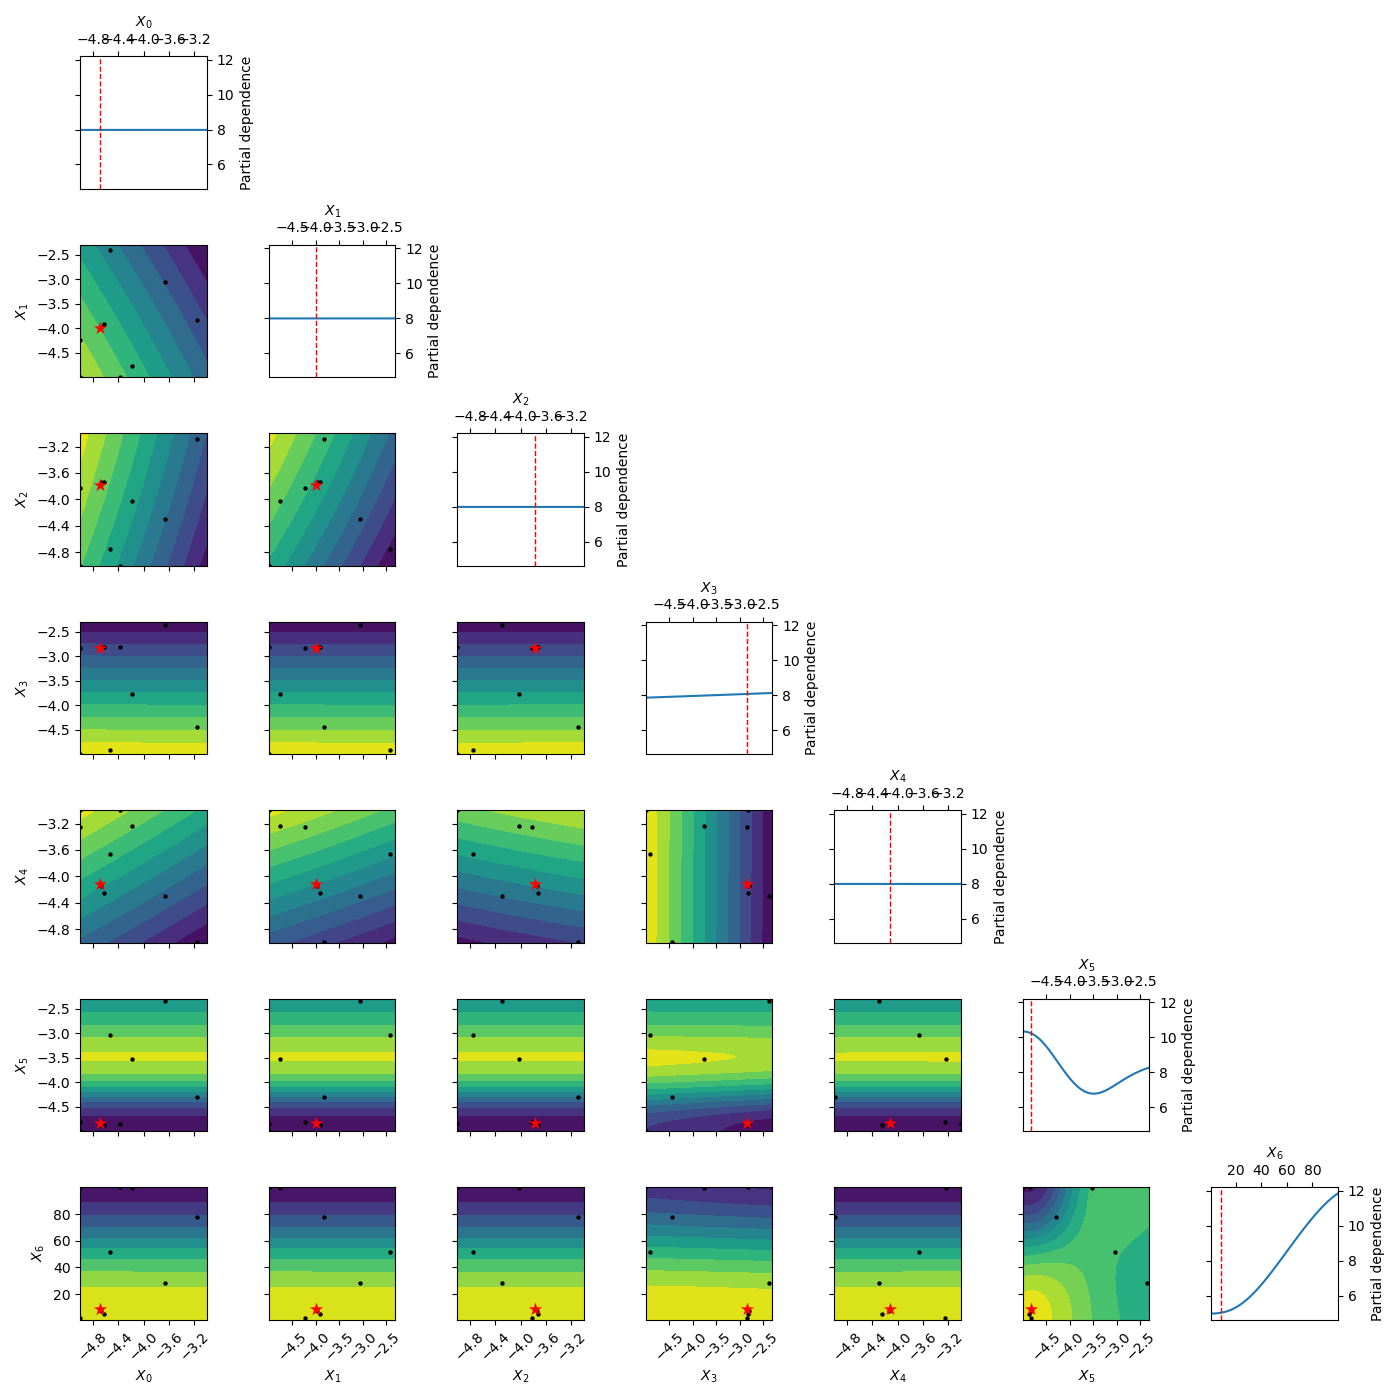

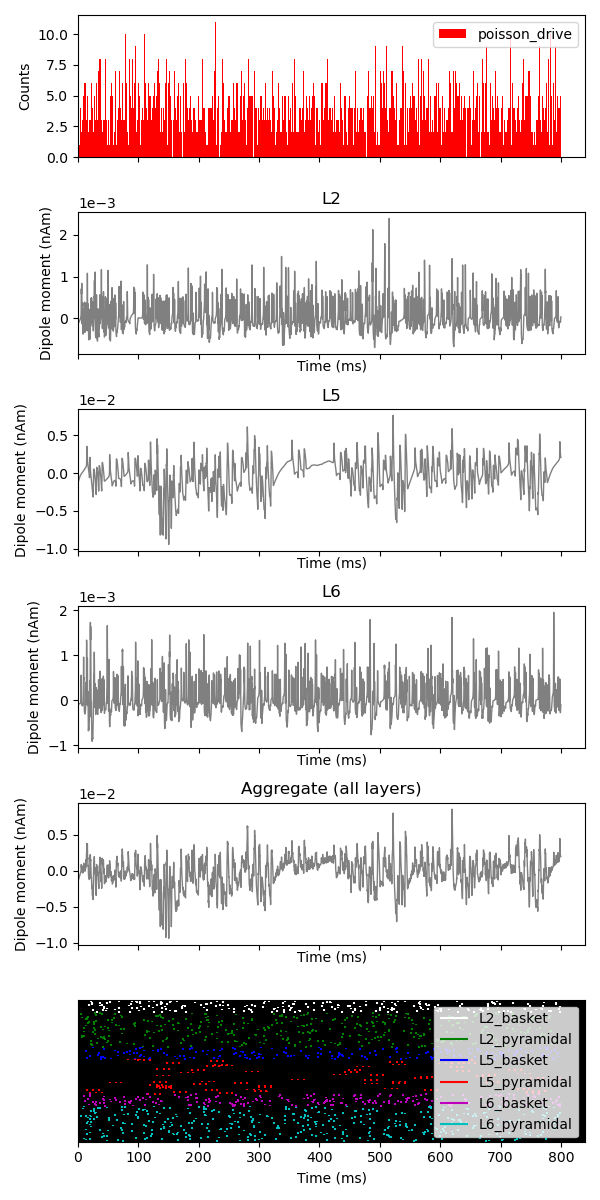

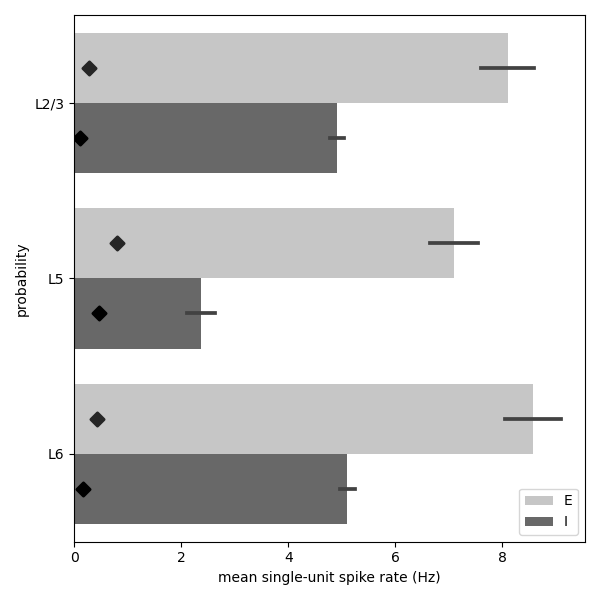

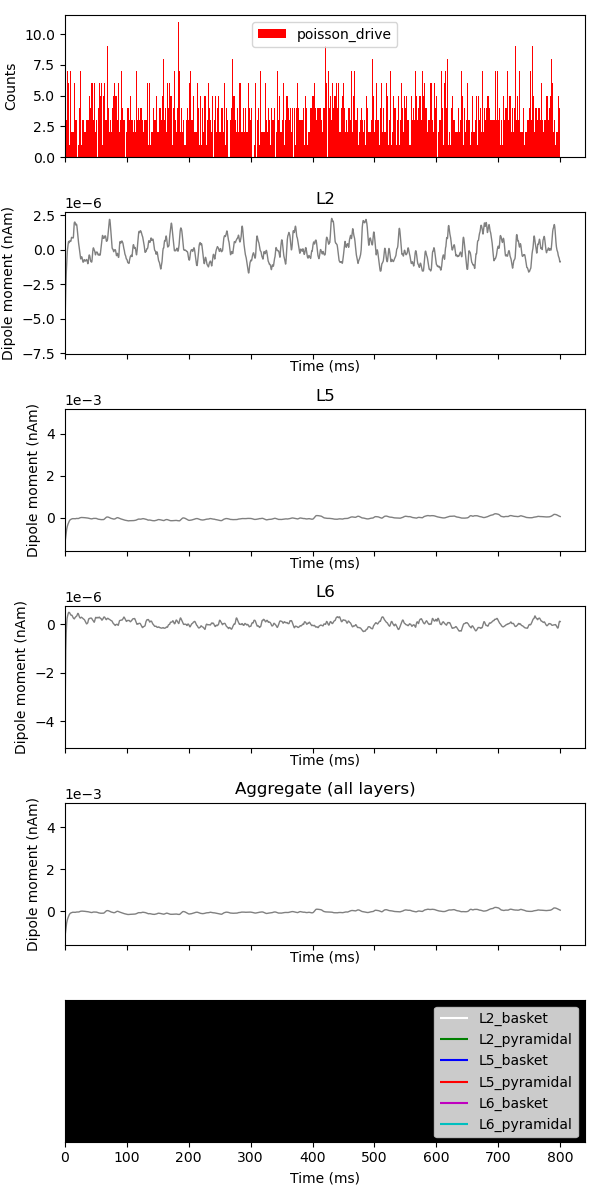

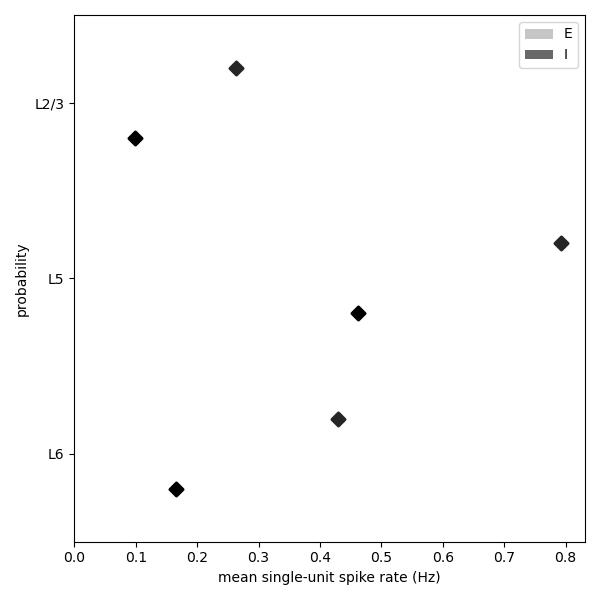

In [7]:
# %% plot results
ax_converg = plot_convergence(opt_results, ax=None)
fig_converge = ax_converg.get_figure()
plt.tight_layout()
#fig_converge.savefig(op.join(output_dir, 'convergence.png'))

ax_objective = plot_objective(opt_results)
fig_objective = ax_objective[0, 0].get_figure()
plt.tight_layout()
#fig_objective.savefig(op.join(output_dir, 'surrogate_objective_func.png'))

# pre-optimization
# first convert first param back from log_10 scale
opt_params_init = [10 ** weight for weight in opt_params_0[:-1]]
opt_params_init.append(opt_params_0[-1])
net_0, dpls_0 = simulate_network(net_original.copy(), sim_time, burn_in_time,
                                 poiss_params=opt_params_init, clear_conn=True,
                                 n_procs=n_procs)

fig_net_response = plot_net_response(dpls_0, net_0, sim_time)
plt.tight_layout()
#fig_net_response.savefig(op.join(output_dir, 'pre_opt_sim.png'))

fig_sr_profiles = plot_spiking_profiles(net_0, sim_time, burn_in_time,
                                        target_spike_rates=target_sr_unconn)
plt.tight_layout()
#fig_sr_profiles.savefig(op.join(output_dir, 'pre_opt_spikerate_profile.png'))

# post-optimization
opt_params_final = [10 ** weight for weight in opt_params[:-1]]
opt_params_final.append(opt_params[-1])
net, dpls = simulate_network(net_original.copy(), sim_time, burn_in_time,
                             poiss_params=opt_params_final, clear_conn=True,
                             n_procs=n_procs)

fig_net_response = plot_net_response(dpls, net, sim_time)
plt.tight_layout()
#fig_net_response.savefig(op.join(output_dir, 'post_opt_sim.png'))

fig_sr_profiles = plot_spiking_profiles(net, sim_time, burn_in_time,
                                        target_spike_rates=target_sr_unconn)
plt.tight_layout()
#fig_sr_profiles.savefig(op.join(output_dir, 'post_opt_spikerate_profile.png'))

print('baseline drive optimization routine completed successfully!!!')

simulating disconnected network
MPI will run 1 trial(s) sequentially by distributing network neurons over 12 processes.
numprocs=12
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_6

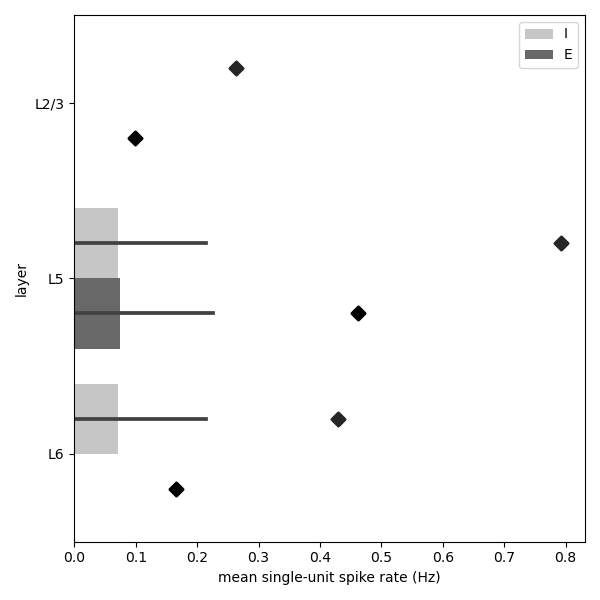

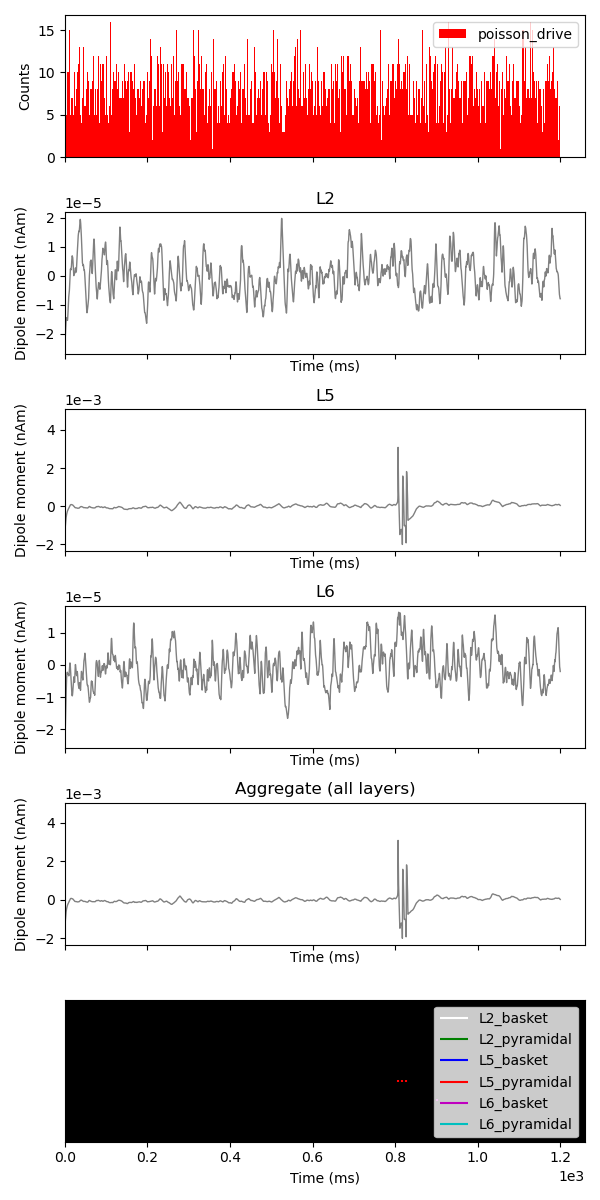

In [59]:
poiss_weights = OrderedDict(L2_basket=4.8e-4, L2_pyramidal=6.2e-4,
                            L5_basket=4.8e-4, L5_pyramidal=20.5e-4,
                            L6_basket=4.8e-4, L6_pyramidal=6.2e-4)


opt_params_init = list(poiss_weights.values())
opt_params_init.append(poiss_rate_0)
net_0, dpls_0 = simulate_network(net_original.copy(), 1200, 200,
                                 poiss_params=opt_params_init, clear_conn=True,
                                 n_procs=n_procs)

fig_net_response = plot_net_response(dpls_0, net_0, sim_time)
plt.tight_layout()

fig_sr_profiles = plot_spiking_profiles(net_0, sim_time, burn_in_time,
                                        target_spike_rates=target_sr_unconn)
plt.tight_layout()
plt.show()

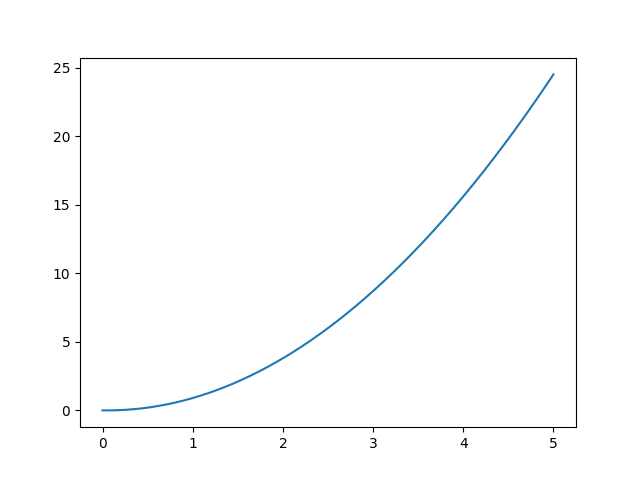

In [15]:
targ = 0.05
x = np.linspace(0.00001, 5, 1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, np.array(x - targ)**2)

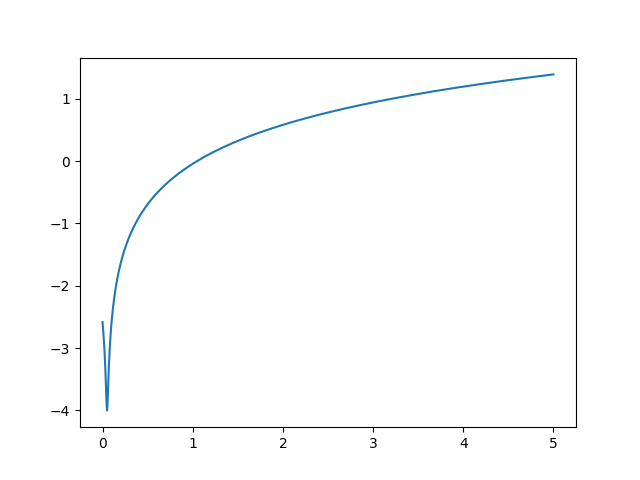

In [17]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, np.log10(1e-4 + (x - targ)**2))

simulating disconnected network
MPI will run 1 trial(s) sequentially by distributing network neurons over 12 processes.
numprocs=12
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.soLoading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so

Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ryan/hnn-core/hnn_core/mod/x86_6

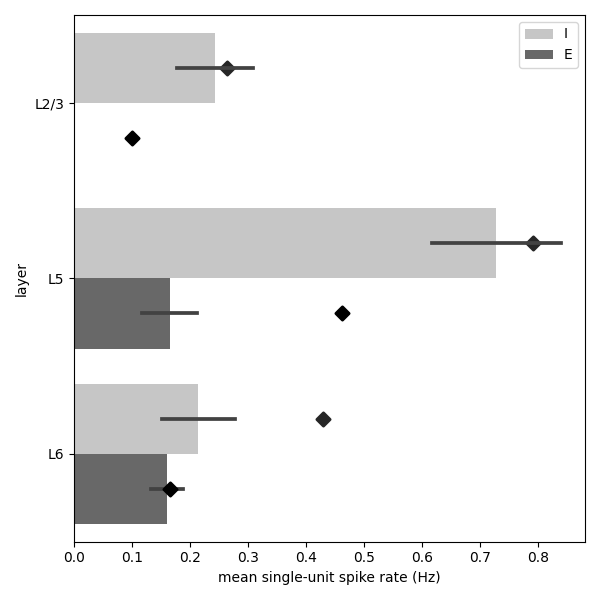

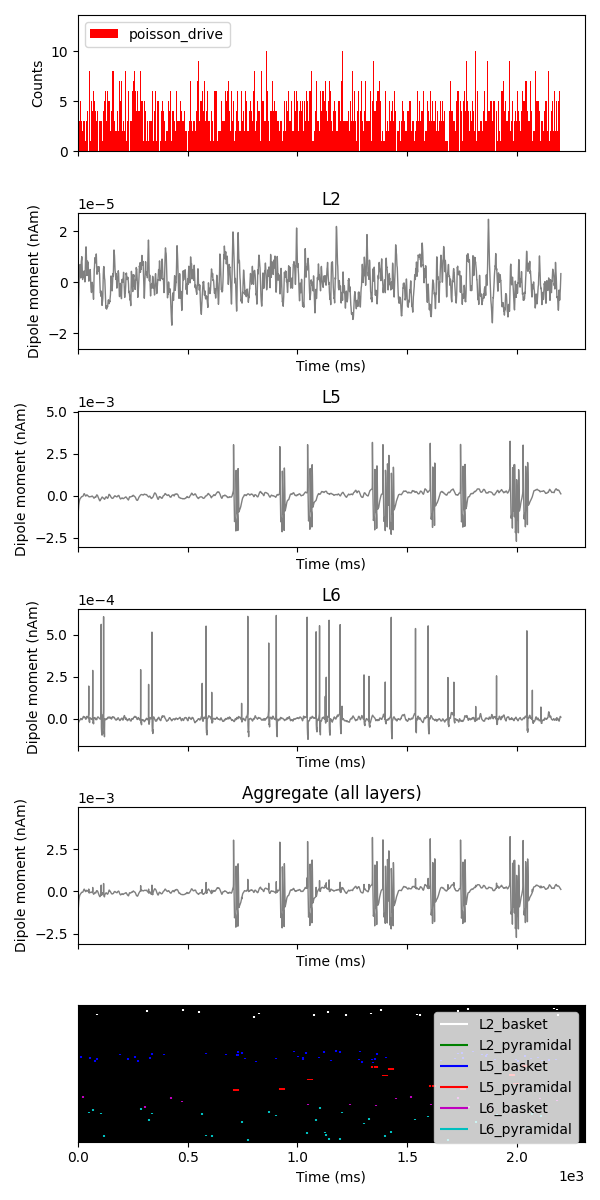

In [3]:
poiss_params = [5.629364213621634687e-04,
                6.323304207947047029e-04,
                9.758222002765683288e-04,
                2.676056142493061629e-03,
                6.866627970974617046e-04,
                9.491956985724239824e-04,
                poiss_rate_0]

sim_time = 2200
burn_in_time = 200

net, dpls = simulate_network(net_original.copy(), sim_time, burn_in_time,
                             poiss_params=poiss_params, clear_conn=True,
                             n_procs=n_procs)

fig_net_response = plot_net_response(dpls, net, sim_time)
plt.tight_layout()

fig_sr_profiles = plot_spiking_profiles(net, sim_time, burn_in_time,
                                        target_spike_rates=target_sr_unconn)
plt.tight_layout()
plt.show()

In [42]:
print(opt_params_init)
print(poiss_params)

[0.0005, 0.00088, 0.0005, 0.00255, 0.0005, 0.00088, 10.0]
[0.000695258186915625, 0.0008800000000000001, 0.0006931044847165894, 0.002549999999999999, 0.0006624029871571344, 0.0008800000000000001, 10.0]
